In [93]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import warnings

In [94]:
# filtering warnings
warnings.filterwarnings('ignore')

### Задание 1
Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

In [41]:
#upload the date from loc
auth_data = pd.read_csv('/Users/apetrukh/Desktop/karpov/final_project/problem1-auth_data.csv', sep=';')
reg_data = pd.read_csv('/Users/apetrukh/Desktop/karpov/final_project/problem1-reg_data.csv', sep=';')

##### 1.1. Изучение данных 
Проверим типы данных и приведем к нужным форматам

In [42]:
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [43]:
reg_data.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [44]:
auth_data.dtypes

auth_ts    object
uid         int64
dtype: object

In [45]:
reg_data.dtypes

reg_ts    object
uid        int64
dtype: object

Проверка на наличие дубликатов

In [46]:
auth_data.loc[auth_data.duplicated()]

,auth_ts,uid


In [47]:
reg_data.loc[reg_data.duplicated()]

,reg_ts,uid


Проверка пропущенных значений

In [48]:
auth_data.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [49]:
reg_data.isna().sum()

reg_ts    0
uid       0
dtype: int64

Конвертируем колонку дата в формат datetime

In [50]:
auth_data.auth_ts = pd.to_datetime(auth_data.auth_ts, unit='s')
auth_data.head()

,auth_ts,uid
0,1998-11-18 09:43:28,1
1,1999-07-22 22:37:52,2
2,1999-07-25 16:46:56,2
3,1999-07-31 03:50:24,2
4,1999-08-05 17:49:52,2


In [51]:
auth_data.dtypes

auth_ts    datetime64[ns]
uid                 int64
dtype: object

In [52]:
reg_data.reg_ts = pd.to_datetime(reg_data.reg_ts, unit='s')
reg_data.head()

,reg_ts,uid
0,1998-11-18 09:43:28,1
1,1999-07-22 22:37:52,2
2,2000-01-13 22:27:12,3
3,2000-05-28 14:18:40,4
4,2000-09-16 11:21:36,5


In [53]:
reg_data

,reg_ts,uid
0,1998-11-18 09:43:28,1
1,1999-07-22 22:37:52,2
2,2000-01-13 22:27:12,3
3,2000-05-28 14:18:40,4
4,2000-09-16 11:21:36,5
...,...,...
999995,2020-09-23 15:13:04,1110618
999996,2020-09-23 15:15:12,1110619
999997,2020-09-23 15:15:12,1110620
999998,2020-09-23 15:17:20,1110621


In [54]:
reg_data.dtypes

reg_ts    datetime64[ns]
uid                int64
dtype: object

##### 1.2. Тестовый сегмент данных

Выберем кусок данных с 20-го августа 202о года, чтобы упростить расчет и визуалзацию.

In [71]:
#We will take users with registration date in august 2020 year
start_date = datetime.strptime('20082020', "%d%m%Y").date()
end_date = datetime.strptime('01092020', "%d%m%Y").date()

reg_data = reg_data.query("reg_ts >= @start_date & reg_ts < @end_date")
reg_data.head()

,reg_ts,uid
944634,2020-08-20 00:00:00,1049172
944635,2020-08-20 00:00:00,1049173
944636,2020-08-20 00:02:08,1049174
944637,2020-08-20 00:02:08,1049175
944638,2020-08-20 00:02:08,1049177


##### 1.3. Алгоритм расчета retention

In [72]:
# Take all users who registered and may have auth actions. Convert datetime to dates due to task condition
reg_auth = reg_data.merge(auth_data, how='left', on='uid')

# Count diff between reg day and uth days
reg_auth["return_day_number"] = (reg_auth.auth_ts - reg_auth.reg_ts).dt.days

reg_auth.reg_ts = reg_auth.reg_ts.dt.date
reg_auth.auth_ts = reg_auth.auth_ts.dt.date

# Calculate the number of users who made a registration in each month
first_reg_counts = reg_auth.groupby(['reg_ts'], as_index=False) \
                                .agg({'uid': pd.Series.nunique}) \
                                .rename(columns={'uid':'first_reg_counts'})

# Calculate the number of users who returned in each month after registration
retention_counts = reg_auth.groupby(['reg_ts', 'return_day_number'], as_index=False) \
                                .agg({'uid': pd.Series.nunique}) \
                                .rename(columns={'uid':'retention_counts'})

# Join agg data about reg date and retention dates
retention_rates = retention_counts.merge(first_reg_counts, how='inner', on='reg_ts')

# Calculate the retention rate for each day after registration
retention_rates['retention_rates'] = round(retention_rates.retention_counts / retention_rates.first_reg_counts * 100, 2)

# Display the retention rates
retention_rates.sort_values(['reg_ts', 'return_day_number'])

,reg_ts,return_day_number,retention_counts,first_reg_counts,retention_rates
0,2020-08-20,0,1555,1555,100.00
1,2020-08-20,1,60,1555,3.86
2,2020-08-20,2,85,1555,5.47
3,2020-08-20,3,79,1555,5.08
4,2020-08-20,4,93,1555,5.98
...,...,...,...,...,...
349,2020-08-31,19,68,1583,4.30
350,2020-08-31,20,58,1583,3.66
351,2020-08-31,21,53,1583,3.35
352,2020-08-31,22,42,1583,2.65


##### 1.4. Визуализация retention через heatmap

<AxesSubplot: xlabel='return_day_number', ylabel='reg_ts'>

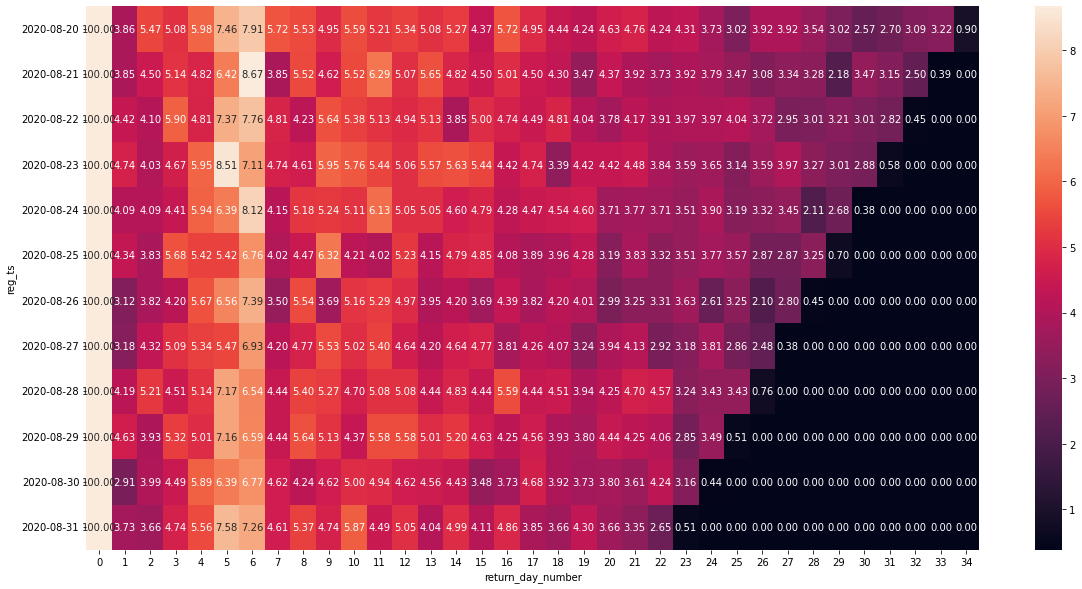

In [73]:
# Vizualisation of retention in %
retention_rates_pivot = retention_rates.pivot(index=['reg_ts'], columns='return_day_number', values='retention_rates').fillna(0)
vmax = retention_rates.query("retention_rates != 100").retention_rates.max()
vmin = retention_rates.query("retention_rates != 100").retention_rates.min()
plt.subplots(figsize=(20,10)) 
sns.heatmap(retention_rates_pivot, annot=True, fmt=".2f", vmin=vmin, vmax=vmax)

Важно смотреть на повередие абсолютных значений (количества пользователей), чтобы объективно оценивать % соотношения retention.

##### 1.5. Визуализация retention через replot

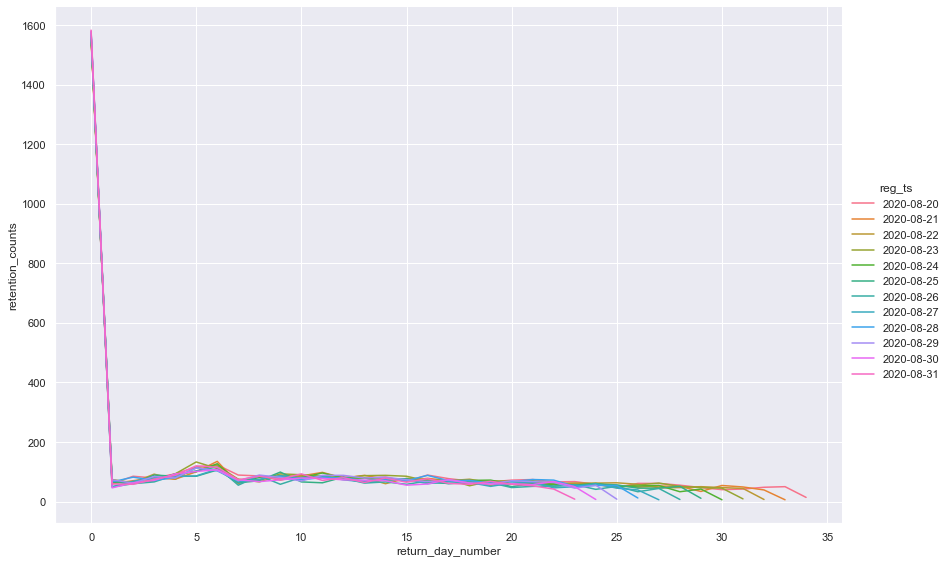

In [80]:
# Vizualisation of retention in abs values
sns.set(style="darkgrid")
sns.relplot(data=retention_rates, x="return_day_number", y="retention_counts", hue="reg_ts", kind="line", height=8, aspect=1.5)

##### 1.6. Создадим функцию на основе алгортима выше

In [109]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def calculate_retention_rates(start_date, end_date, reg_data, auth_data):
    # Convert sec to datetime format
    auth_data.auth_ts = pd.to_datetime(auth_data.auth_ts, unit='s')
    reg_data.reg_ts = pd.to_datetime(reg_data.reg_ts, unit='s')

    # Filter registration data based on start_date and end_date
    start_date = datetime.strptime(start_date, "%d%m%Y").date()
    end_date = datetime.strptime(end_date, "%d%m%Y").date()
    reg_data = reg_data.query("reg_ts >= @start_date & reg_ts < @end_date")

    # Merge registration and authentication data
    reg_auth = reg_data.merge(auth_data, how='left', on='uid')
    
    # Calculate the number of days between registration and authentication
    reg_auth["return_day_number"] = (reg_auth.auth_ts - reg_auth.reg_ts).dt.days
    reg_auth.reg_ts = reg_auth.reg_ts.dt.date
    reg_auth.auth_ts = reg_auth.auth_ts.dt.date
    
    # Calculate the number of users who made a registration in each month
    first_reg_counts = reg_auth.groupby(['reg_ts'], as_index=False) \
                                .agg({'uid': pd.Series.nunique}) \
                                .rename(columns={'uid':'first_reg_counts'})
    
    # Calculate the number of users who returned in each month after registration
    retention_counts = reg_auth.groupby(['reg_ts', 'return_day_number'], as_index=False) \
                                .agg({'uid': pd.Series.nunique}) \
                                .rename(columns={'uid':'retention_counts'})
    
    # Join agg data about reg date and retention dates
    retention_rates = retention_counts.merge(first_reg_counts, how='inner', on='reg_ts')
    
    # Calculate the retention rate for each day after registration
    retention_rates['retention_rates'] = round(retention_rates.retention_counts / retention_rates.first_reg_counts * 100, 2)
    
    # Sort the retention rates
    retention_rates = retention_rates.sort_values(['reg_ts', 'return_day_number'])

    # Display the retention rates
    print(retention_rates)
    
    # Pivot the retention rates for visualization
    retention_rates_pivot = retention_rates.pivot(index=['reg_ts'], columns='return_day_number', values='retention_rates').fillna(0)
    vmax = retention_rates.query("retention_rates != 100").retention_rates.max()
    vmin = retention_rates.query("retention_rates != 100").retention_rates.min()
    
    # Plot the retention rates heatmap
    plt.subplots(figsize=(20, 10))
    sns.heatmap(retention_rates_pivot, annot=True, fmt=".2f", vmin=vmin, vmax=vmax)
    plt.show()

    # Vizualisation of retention in abs values
    sns.set(style="darkgrid")
    sns.relplot(data=retention_rates, x="return_day_number", y="retention_counts", hue="reg_ts", kind="line", height=8, aspect=1.5)
    plt.show()

##### 1.7. Проверим точность расчетов функции на тестовых данных

- uid 4 and 5 should be filtered
- for 2020-08-20 should be 100% (0), 50% (1), 50% (2)
- for 2020-08-22 should be 100% (0), 100% (1), 0% (2)

       reg_ts  return_day_number  retention_counts  first_reg_counts   
0  2020-08-20                  0                 2                 2  \
1  2020-08-20                  1                 1                 2   
2  2020-08-20                  2                 1                 2   
3  2020-08-22                  0                 1                 1   
4  2020-08-22                  1                 1                 1   

   retention_rates  
0            100.0  
1             50.0  
2             50.0  
3            100.0  
4            100.0  


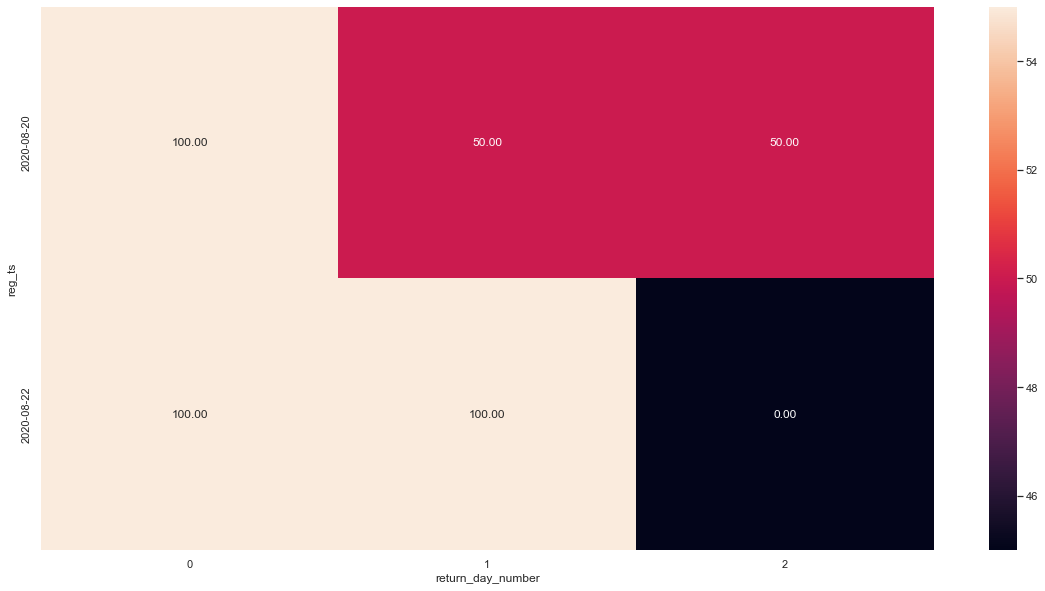

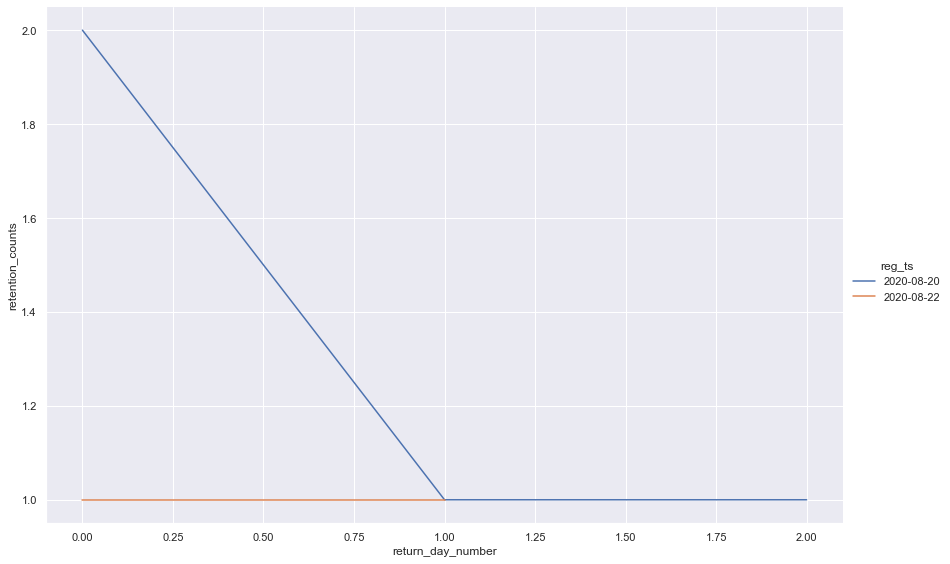

In [113]:
# Testing data
reg_data = pd.DataFrame({
    'uid': [1, 2, 3, 4, 5],
    'reg_ts': [
        datetime(2020, 8, 20, 10, 0, 0),
        datetime(2020, 8, 20, 12, 0, 0),
        datetime(2020, 8, 22, 15, 0, 0),
        datetime(2020, 9, 25, 9, 0, 0),
        datetime(2020, 8, 18, 9, 0, 0)
    ]
})

auth_data = pd.DataFrame({
    'uid': [1, 2, 3, 4, 5, 1, 2, 3, 3, 4, 5],
    'auth_ts': [
        datetime(2020, 8, 20, 10, 0, 0),
        datetime(2020, 8, 20, 12, 0, 0),
        datetime(2020, 8, 22, 15, 0, 0),
        datetime(2020, 9, 25, 9, 0, 0),
        datetime(2020, 8, 18, 9, 0, 0),
        datetime(2020, 8, 21, 10, 0, 0),
        datetime(2020, 8, 22, 12, 0, 0),
        datetime(2020, 8, 23, 15, 0, 0),
        datetime(2020, 8, 24, 12, 0, 0),
        datetime(2020, 9, 26, 9, 0, 0),
        datetime(2020, 8, 26, 12, 0, 0)
    ]
})

start_date = '20082020'
end_date = '01092020'

calculate_retention_rates(start_date, end_date, reg_data, auth_data)

##### 1.8. Расчитаем сегмент данных из задачи для пользователей зарегистрировавшися в период с 20-08-2020 по 31-08-2020

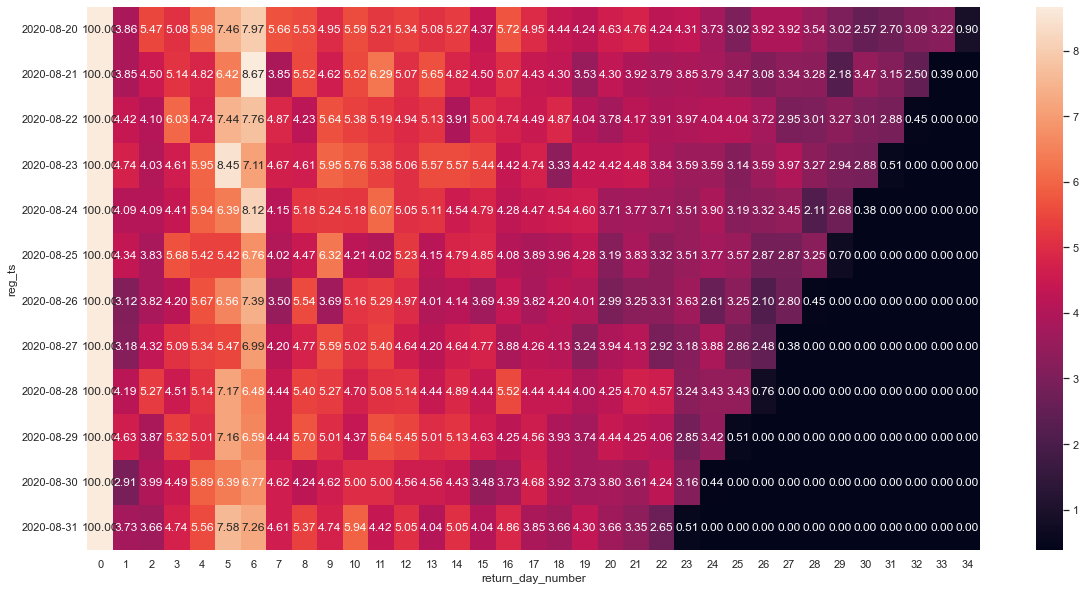

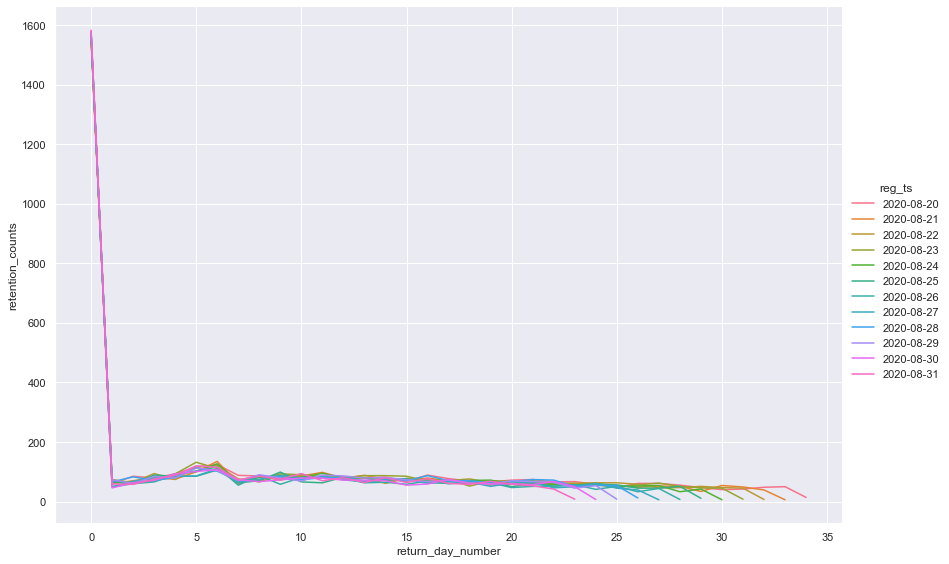

In [108]:
# We can choose period of registraation for users
start_date = '20082020'
end_date = '01092020'
auth_data = pd.read_csv('/Users/apetrukh/Desktop/karpov/final_project/problem1-auth_data.csv', sep=';')
reg_data = pd.read_csv('/Users/apetrukh/Desktop/karpov/final_project/problem1-reg_data.csv', sep=';')

calculate_retention_rates(start_date, end_date, reg_data, auth_data)

**Вывод: абсолютные значения количества пользователей однороды в течение выбранного промежутка времени --> можем сравнивать % значения retenion для нужного нам промежутка времени**